# Decision Tree

In [22]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd 

from pydataset import data

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

In [47]:
import env

def get_connection(db, user=env.user, host=env.host, password=env.password):
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'

def get_titanic():
    my_query="SELECT * FROM passengers"
    df = pd.read_sql(my_query, get_connection('titanic_db'))
    return df

def clean_titanic_data(df):
    '''
    This function will clean the data
    '''
    df = df.drop_duplicates()
    cols_to_drop = ['deck', 'embarked', 'class', 'age', 'embark_town', 'sex']
    df['embark_town'] = df.embark_town.fillna(value='Southampton')
    dummy_df = pd.get_dummies(df[['sex', 'embark_town']], dummy_na=False, drop_first=[True, False])
    df = pd.concat([df, dummy_df], axis=1)
    df = df.drop(columns=cols_to_drop)
    return df

def split_titanic_data(df):
    '''
    Takes in a dataframe and returns train, validate, test subset dataframes
    '''
    train, test = train_test_split(df, test_size = .2, random_state = 123, stratify=df.survived)
    train, validate = train_test_split(train, test_size = .3, random_state = 123, stratify=train.survived)
    return train, validate, test

In [48]:
titanic_df = get_titanic()
titanic_df = clean_titanic_data(titanic_df)
titanic_df["baseline_prediction"] = 0
titanic_df.head()

,passenger_id,survived,pclass,sibsp,parch,fare,alone,sex_male,embark_town_Queenstown,embark_town_Southampton,baseline_prediction
0,0,0,3,1,0,7.2500,0,1,0,1,0
1,1,1,1,1,0,71.2833,0,0,0,0,0
2,2,1,3,0,0,7.9250,1,0,0,1,0
3,3,1,1,1,0,53.1000,0,0,0,1,0
4,4,0,3,0,0,8.0500,1,1,0,1,0


In [49]:
train, validate, test = split_titanic_data(titanic_df)
print(f'Train: {train.shape}')
print(f'Test: {test.shape}')
print(f'Validate: {validate.shape}')

Train: (498, 11)
Test: (179, 11)
Validate: (214, 11)


In [50]:
# Using the titanic data, in your classification-exercises repository, create a notebook, 
# model.ipynb where you will do the following:

# What is your baseline prediction? What is your baseline accuracy? remember: your baseline prediction 
# for a classification problem is predicting the most prevelant class in the training dataset (the mode). 
# When you make those predictions, what is your accuracy? This is your baseline accuracy.

In [51]:
# What is the most prevalent value in survived?
titanic_df.survived.value_counts()

0    549
1    342
Name: survived, dtype: int64

In [52]:
baseline_accuracy = (train.baseline_prediction == train.survived).mean()
print(f'Baseline Accuracy (Predicts did not survive): {baseline_accuracy:.2%}')

Baseline Accuracy (Predicts did not survive): 61.65%


In [53]:
# Fit the decision tree classifier to your training sample and transform 
# (i.e. make predictions on the training sample)

X_train = train.drop(columns=['survived'])
y_train = train.survived

X_validate = validate.drop(columns=['survived'])
y_validate = validate.survived

X_test = test.drop(columns=['survived'])
y_test = test.survived

In [54]:
# for classification you can change the algorithm to gini or entropy (information gain).  
# Default is gini.

clf = DecisionTreeClassifier(max_depth=3, random_state=123)

In [55]:
# model.fit(X, y)

clf = clf.fit(X_train, y_train)

In [64]:
import graphviz
from graphviz import Graph

In [70]:
dot_data = export_graphviz(clf, feature_names= X_train.columns, rounded=True, filled=True, out_file=None)
graph = graphviz.Source(dot_data) 

In [71]:
graph.render('titanic_decision_tree', view=True)

'titanic_decision_tree.pdf'

In [59]:
# make prediction on train obeservations

y_pred = clf.predict(X_train)
y_pred[0:5]

array([0, 0, 0, 1, 1])

In [60]:
# estimate probability of survival using the training data

y_pred_proba = clf.predict_proba(X_train)
y_pred_proba[0:5]

array([[0.62222222, 0.37777778],
       [0.62222222, 0.37777778],
       [0.89285714, 0.10714286],
       [0.14814815, 0.85185185],
       [0.        , 1.        ]])

In [61]:
# Evaluate your in-sample results using the model score, confusion matrix, and classification report.

# Compute the Accuracy.  Accuracy is the number of correct predictions over the 
# number of total instances that have been evaluated.

print('Accuracy of Decision Tree classifier on training set: {:.2f}'
      .format(clf.score(X_train, y_train)))

Accuracy of Decision Tree classifier on training set: 0.82


In [62]:
# confusion matrix

confusion_matrix(y_train, y_pred)

array([[274,  33],
       [ 56, 135]])

In [63]:
y_train.value_counts()

0    307
1    191
Name: survived, dtype: int64

In [68]:
# Compute: Accuracy, true positive rate, false positive rate, true negative rate, 
# false negative rate, precision, recall, f1-score, and support.

# Create labels based on unique elements in the y/target variable set
labels = ['Perished', 'Survived']

pd.DataFrame(confusion_matrix(y_train, y_pred), index=labels, columns=labels)

,Perished,Survived
Perished,274,33
Survived,56,135


In [67]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86       307
           1       0.80      0.71      0.75       191

    accuracy                           0.82       498
   macro avg       0.82      0.80      0.81       498
weighted avg       0.82      0.82      0.82       498



In [69]:
#Evaluating the Model with our Validate dataset
#Compute the accuracy of the model when run on the validate data
#Because we didn't do exploration or train on validate, it is "out-of-sample".
#Evaluating on validate means we're learning how well the model does on new data.

print('Accuracy of Decision Tree classifier on validate set: {:.2f}'
     .format(clf.score(X_validate, y_validate)))

Accuracy of Decision Tree classifier on validate set: 0.78


In [ ]:
# Run through steps 2-4 using a different max_depth value.



In [ ]:
# Which model performs better on your in-sample data?



In [ ]:
# Which model performs best on your out-of-sample data, the validate set?

# Random Tree

In [ ]:
# 1. Fit the Random Forest classifier to your training sample and transform (i.e. make predictions 
# on the training sample) setting the random_state accordingly and setting min_samples_leaf = 1 and max_depth = 10.



# KNN

In [73]:
from sklearn.neighbors import KNeighborsClassifier

In [74]:
# weights = ['uniform', 'density']
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')

In [75]:
# fit the model
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [77]:
# make predictions
y_pred = knn.predict(X_train)

In [78]:
# estimate probability
y_pred_proba = knn.predict_proba(X_train)

In [79]:
# computer the accuracy
print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))

Accuracy of KNN classifier on training set: 0.74


In [80]:
# create the confusion matrix
print(confusion_matrix(y_train, y_pred))

[[270  37]
 [ 92  99]]


In [81]:
# create the classification report
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.88      0.81       307
           1       0.73      0.52      0.61       191

    accuracy                           0.74       498
   macro avg       0.74      0.70      0.71       498
weighted avg       0.74      0.74      0.73       498



In [82]:
# validate/evaluate on out-of-sample data
print('Accuracy of KNN classifier on test set: {:.2f}'
     .format(knn.score(X_validate, y_validate)))

Accuracy of KNN classifier on test set: 0.57


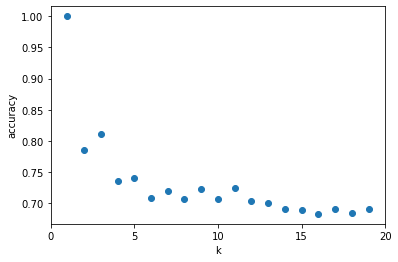

In [88]:
# visualize the models across a k range from 1 to 20 on out-of-sample data
import matplotlib.pyplot as plt
k_range = range(1, 20)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k, weights='uniform')
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_train, y_train))
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,15,20])
plt.show()

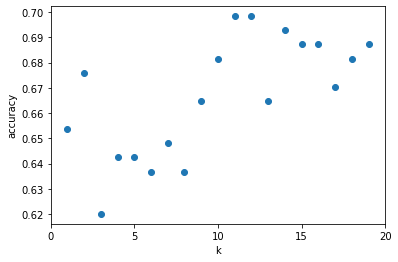

In [86]:
# visualize the models across a k range from 1 to 20 
k_range = range(1, 20)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k, weights='uniform')
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_test, y_test))
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,15,20])
plt.show()

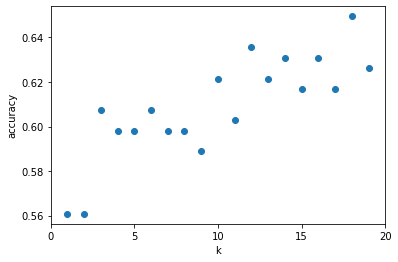

In [90]:
# visualize the models across a k range from 1 to 20, with 
k_range = range(1, 20)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k, weights='distance')
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_validate, y_validate))
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,15,20])
plt.show()

In [91]:
X_train.head()

,passenger_id,pclass,sibsp,parch,fare,alone,sex_male,embark_town_Queenstown,embark_town_Southampton,baseline_prediction
583,583,1,0,0,40.1250,1,1,0,0,0
165,165,3,0,2,20.5250,0,1,0,1,0
50,50,3,4,1,39.6875,0,1,0,1,0
259,259,2,0,1,26.0000,0,0,0,1,0
306,306,1,0,0,110.8833,1,0,0,0,0


# Logistic Regression

# Decision Tree Lesson

In [2]:
# read Iris data from pydatset
df = data('iris')

df.head()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
1,5.1,3.5,1.4,0.2,setosa
2,4.9,3.0,1.4,0.2,setosa
3,4.7,3.2,1.3,0.2,setosa
4,4.6,3.1,1.5,0.2,setosa
5,5.0,3.6,1.4,0.2,setosa


In [3]:
# convert column names to lowercase, replace '.' in column names with '_'
df.columns = [col.lower().replace('.', '_') for col in df]

# Splitting

In [4]:
def train_validate_test_split(df, target, seed=123):
    '''
    This function takes in a dataframe, the name of the target variable
    (for stratification purposes), and an integer for a setting a seed
    and splits the data into train, validate and test. 
    Test is 20% of the original dataset, validate is .30*.80= 24% of the 
    original dataset, and train is .70*.80= 56% of the original dataset. 
    The function returns, in this order, train, validate and test dataframes. 
    '''
    train_validate, test = train_test_split(df, test_size=0.2, 
                                            random_state=seed, 
                                            stratify=df[target])
    train, validate = train_test_split(train_validate, test_size=0.3, 
                                       random_state=seed,
                                       stratify=train_validate[target])
    return train, validate, test

In [5]:
# split into train, validate, test
train, validate, test = train_validate_test_split(df, target='species', seed=123)

In [8]:
train.shape

(84, 5)

In [10]:
validate.shape

(36, 5)

In [6]:
# create X & y version of train, where y is a series with just the target variable and X are all the features. 

X_train = train.drop(columns=['species'])
y_train = train.species

X_validate = validate.drop(columns=['species'])
y_validate = validate.species

X_test = test.drop(columns=['species'])
y_test = test.species

In [11]:
X_train.shape

(84, 4)

# Training the Model

### Create the object

In [13]:
# Create the Decision Tree object with desired hyper-parameters.
# clf : classifier

clf = DecisionTreeClassifier(max_depth=3, random_state=123)

### Fit the model

In [14]:
# Fit (aka train) the model (i.e. apply the algorithm to your unique set of data so that the algorithm can identify a pattern)
# model.fit(X, y)

clf = clf.fit(X_train, y_train)

### Vizualize the tree

In [15]:
# gini: a measure of how 'impure' a node/leaf is, gini impurity : liklihood of making an incorrect prediction
import graphviz
from graphviz import Graph

dot_data = export_graphviz(clf, feature_names= X_train.columns, class_names=clf.classes_, rounded=True, filled=True, out_file=None)
graph = graphviz.Source(dot_data) 

graph.render('iris_decision_tree', view=True)

'iris_decision_tree.pdf'

### Make Predictions

Classify each flower

In [16]:
# make prediction on train obeservations

y_pred = clf.predict(X_train)
y_pred[0:5]

array(['versicolor', 'setosa', 'virginica', 'versicolor', 'setosa'],
      dtype=object)

### Estimate Probability

Estimate the probability of each species

In [17]:
y_pred_proba = clf.predict_proba(X_train)
y_pred_proba[0:5]

array([[0.        , 1.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [0.        , 0.03703704, 0.96296296],
       [0.        , 1.        , 0.        ],
       [1.        , 0.        , 0.        ]])

## Evaluate the Model

### Compute Accuracy

In [18]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
      .format(clf.score(X_train, y_train)))

Accuracy of Decision Tree classifier on training set: 0.96


### Create a Confusion Matrix

In [19]:
# confusion matrix

confusion_matrix(y_train, y_pred)

array([[28,  0,  0],
       [ 0, 27,  1],
       [ 0,  2, 26]])

In [20]:
y_train.value_counts()

virginica     28
versicolor    28
setosa        28
Name: species, dtype: int64

In [21]:
labels = sorted(y_train.unique())
print('Actual on the left, predicted on the top')
pd.DataFrame(confusion_matrix(y_train, y_pred), index=labels, columns=labels)

Actual on the left, predicted on the top


,setosa,versicolor,virginica
setosa,28,0,0
versicolor,0,27,1
virginica,0,2,26


### Create a Classification Report

- **Precision**: the higher this number is, the more you were able to pinpoint all positives correctly. If this is a low score, you predicted a lot of positives where there were none.
- **Recall**: if this score is high, you didn’t miss a lot of positives. But as it gets lower, you are not predicting the positives that are actually there.
- **f1-score**: The balanced harmonic mean of Recall and Precision, giving both metrics equal weight. The higher the F-Measure is, the better.
- **Support**: number of occurrences of each class in where y is true.

In [ ]:
print(classification_report(y_train, y_pred))

## Evaluate Performance with Validate Set

In [ ]:
print('Accuracy of Decision Tree classifier on validate set: {:.2f}'
     .format(clf.score(X_validate, y_validate)))

In [ ]:
# And since accuracy isn't everything

# Produce y_predictions that come from the X_validate
y_pred = clf.predict(X_validate)

# Compare actual y values (from validate) to predicted y_values from the model run on X_validate
print(classification_report(y_validate, y_pred))
